# How to implement data augmentation
Tensorflow에서 `tf.image` 를 활용하여 image recognition을 수행하는 model을 training할 때, **data augmentation** 을 적용하는 방법에 대하여 정리, 아래의 상황을 가정

- image는 `(256, 256, 3)` 의 shape를 가진다.
- 실제 training 할 때, Convolution Neural Network model은 `(224, 224, 3)` 의 shape의 image를 input으로 받음

***contents  구성은 아래와 같다.***

* Setup
* Cropping
    + Cropping central
    + Cropping top left
    + Cropping top right
    + Cropping bottom left
    + Cropping bottom right
    + Template
* Warping
* Flipping and adjusting contrast, brightness, saturation, hue
    + Flipping left, right
    + Flipping up, down
    + Adjusting contrast
    + Adjusting brightness
    + Adjusting saturation
    + Adjusting hue
    + Template
* Template

## Setup

In [1]:
import os, sys
import tensorflow as tf
import numpy as np 
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
dog_img = Image.open(fp = './dog.png')
cat_img = Image.open(fp = './cat.jpg')
dog_img = dog_img.resize((256,256))
cat_img = cat_img.resize((256,256))

In [3]:
dog_img = np.asarray(dog_img)[:,:,:3].astype(np.float32).reshape(-1,256,256,3)
cat_img = np.asarray(cat_img).astype(np.float32).reshape(-1,256,256,3)
images = np.r_[dog_img, cat_img]
print(images.shape)

(2, 256, 256, 3)


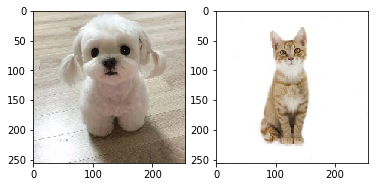

In [4]:
fig = plt.figure()

for idx in range(2):
    ax = fig.add_subplot(1,2,idx+1)
    ax.imshow(images[idx] / 255)

# fig.savefig('./dog_cat.png')

## Cropping
original image가 주어졌을 때 `tf.image` 를 활용하여 central, top left, top right, bottom left, bottom right에 원하는 resolution을 cropping

### Cropping central
image의 중앙을 crop

In [5]:
img = tf.placeholder(dtype = tf.float32, shape = [None, 256, 256, 3])
cropping_ct = tf.image.central_crop(image = img, central_fraction = 224 / 256)
print(cropping_ct)

with tf.Session() as sess:
    cropped_ct = sess.run(cropping_ct, feed_dict = {img : images})

Tensor("central_crop/Slice:0", shape=(?, 224, 224, 3), dtype=float32)


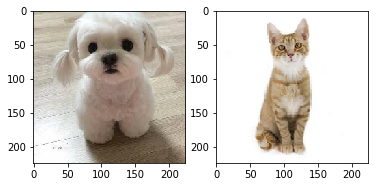

In [6]:
fig = plt.figure()

for idx in range(2):
    ax = fig.add_subplot(1,2,idx+1)
    ax.imshow(cropped_ct[idx] / 255)

# fig.savefig('./dog_cat_cropped_ct.png')

### Cropping top left
image의 좌상단을 crop

In [7]:
tf.reset_default_graph()
img = tf.placeholder(dtype = tf.float32, shape = [None, 256, 256, 3])

cropping_tl = tf.image.crop_to_bounding_box(image = img, offset_height = 0, offset_width = 0,
                                            target_height = 224, target_width = 224)
print(cropping_tl)

with tf.Session() as sess:
    cropped_tl = sess.run(cropping_tl, feed_dict = {img : images})

Tensor("crop_to_bounding_box/Slice:0", shape=(?, 224, 224, 3), dtype=float32)


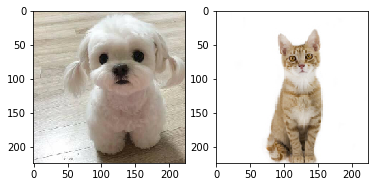

In [8]:
fig = plt.figure()

for idx in range(2):
    ax = fig.add_subplot(1,2,idx+1)
    ax.imshow(cropped_tl[idx] / 255)

# fig.savefig('./dog_cat_cropped_tl.png')

### Cropping top right
image의 우상단을 crop

In [9]:
tf.reset_default_graph()
img = tf.placeholder(dtype = tf.float32, shape = [None, 256, 256, 3])

cropping_tr = tf.image.crop_to_bounding_box(image = img, offset_height = 0, offset_width = 256 - 224,
                                            target_height = 224, target_width = 224)
print(cropping_tr)

with tf.Session() as sess:
    cropped_tr = sess.run(cropping_tr, feed_dict = {img : images})

Tensor("crop_to_bounding_box/Slice:0", shape=(?, 224, 224, 3), dtype=float32)


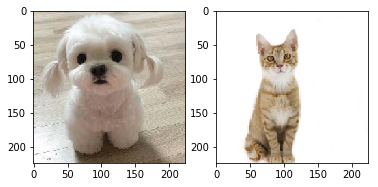

In [10]:
fig = plt.figure()

for idx in range(2):
    ax = fig.add_subplot(1,2,idx+1)
    ax.imshow(cropped_tr[idx] / 255)

# fig.savefig('./dog_cat_cropped_tr.png')

### Cropping bottom left
image의 좌하단을 crop

In [11]:
tf.reset_default_graph()
img = tf.placeholder(dtype = tf.float32, shape = [None, 256, 256, 3])

cropping_bl = tf.image.crop_to_bounding_box(image = img, offset_height = 256-224, offset_width = 0,
                                            target_height = 224, target_width = 224)
print(cropping_bl)

with tf.Session() as sess:
    cropped_bl = sess.run(cropping_bl, feed_dict = {img : images})

Tensor("crop_to_bounding_box/Slice:0", shape=(?, 224, 224, 3), dtype=float32)


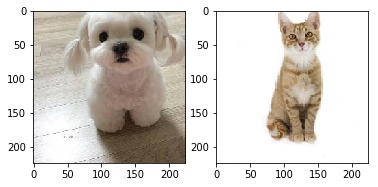

In [12]:
fig = plt.figure()

for idx in range(2):
    ax = fig.add_subplot(1,2,idx+1)
    ax.imshow(cropped_bl[idx] / 255)

# fig.savefig('./dog_cat_cropped_bl.png')

### Cropping bottom right
image의 우하단을 crop

In [13]:
tf.reset_default_graph()
img = tf.placeholder(dtype = tf.float32, shape = [None, 256, 256, 3])

cropping_br = tf.image.crop_to_bounding_box(image = img, offset_height = 256-224, offset_width = 256 - 224,
                                            target_height = 224, target_width = 224)
print(cropping_br)

with tf.Session() as sess:
    cropped_br = sess.run(cropping_br, feed_dict = {img : images})

Tensor("crop_to_bounding_box/Slice:0", shape=(?, 224, 224, 3), dtype=float32)


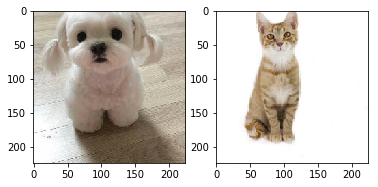

In [14]:
fig = plt.figure()

for idx in range(2):
    ax = fig.add_subplot(1,2,idx+1)
    ax.imshow(cropped_br[idx] / 255)

# fig.savefig('./dog_cat_cropped_br.png')

### Template
위의 augmentation 적용할 때는 `function` 을 만들어놓고, `tf.data.Dataset` class의 instance를 생성한 다음, instane의 `map` instance method를 활용한다.

#### Defining `crop_image function`

In [15]:
# 위의 모든 기능을 function 하나에 모음
tf.reset_default_graph()

def crop_image(img, crop_size, mode = 'ct'):
    assert mode in ['ct', 'tl' , 'tr', 'bl', 'br', 'all'], 'unvalid mode'
    dim_list = img.get_shape().as_list()
    orig_size = dim_list[1]
    target_size = {'target_height' : crop_size, 'target_width' : crop_size}
    
    cropped = {'ct' : tf.image.central_crop(image = img, central_fraction = crop_size / orig_size),
               'tl' : tf.image.crop_to_bounding_box(image = img, offset_height = 0, offset_width = 0,
                                                    **target_size),
               'tr' : tf.image.crop_to_bounding_box(image = img, offset_height = 0,
                                                   offset_width = orig_size - crop_size, **target_size),
               'bl' : tf.image.crop_to_bounding_box(image = img, offset_height = orig_size - crop_size,
                                                     offset_width = 0, **target_size),
               'br' : tf.image.crop_to_bounding_box(image = img, offset_height= orig_size - crop_size,
                                                         offset_width = orig_size - crop_size, **target_size)}
    if mode == 'all':
        return cropped
    else:
        return cropped.get(mode)

#### `tf.data.Dataset` class의 instance의 `map` instance method 활용

In [16]:
dataset = tf.data.Dataset.from_tensor_slices(images)
dataset = dataset.map(lambda elm : crop_image(elm, crop_size = 224, mode = 'tl'))
iterator = dataset.make_one_shot_iterator()
cropped_img = iterator.get_next()

In [17]:
with tf.Session() as sess:
    result = np.array([]).reshape(-1,224,224,3)
    try:
        while True:
            tmp = sess.run(cropped_img)
            tmp = tmp.reshape(-1,224,224,3)
            result = np.r_[result, tmp]
    except tf.errors.OutOfRangeError as e:
        pass

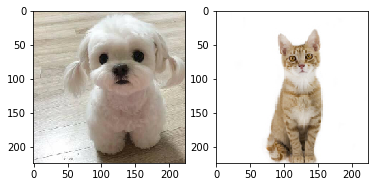

In [18]:
fig = plt.figure()

for idx in range(2):
    ax = fig.add_subplot(1,2,idx+1)
    ax.imshow(result[idx] / 255)

# fig.savefig('./dog_cat_cropped_template.png')

## Warping
Data augmentation이라고 보기보다는 image의 aspect ratio를 무시하고 특정 resolution으로 resize

In [19]:
tf.reset_default_graph()
img = tf.placeholder(dtype = tf.float32, shape = [None, 256, 256, 3])

warping = tf.image.resize_images(images = img, size = (224, 224))
print(warping)

with tf.Session() as sess:
    warped = sess.run(warping, feed_dict = {img : images})

Tensor("resize_images/ResizeBilinear:0", shape=(?, 224, 224, 3), dtype=float32)


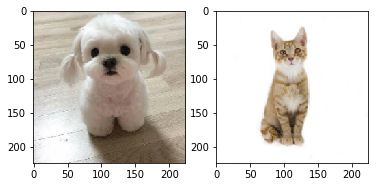

In [20]:
fig = plt.figure()

for idx in range(2):
    ax = fig.add_subplot(1,2,idx+1)
    ax.imshow(warped[idx] / 255)

# fig.savefig('./dog_cat_warped.png')

## Flipping and adjusting contrast, brightness, saturation, hue
original image가 주어졌을 때 `tf.image` 를 활용하여 image를 flipping하거나 contrast(대비), brightness(명도), saturation(채도), hue(색조) 등을 변경
### Flipping left, right
예시로 보여주기위해서 `tf.image.flip_left_right` 를 사용하였으나, 실제 training하기위해서 model에 넘길때는 mini-batch를 뽑을 때마다 무작위성을 부여하기위해 `tf.image.random_flip_left_right` 를 사용한다.

In [21]:
tf.reset_default_graph()
img = tf.placeholder(dtype = tf.float32, shape = [None, 256, 256, 3])

flipping_lr = tf.image.flip_left_right(image = img) #random
print(flipping_lr)

with tf.Session() as sess:
    flipped_lr = sess.run(flipping_lr, feed_dict = {img : images})

Tensor("flip_left_right/ReverseV2:0", shape=(?, 256, 256, 3), dtype=float32)


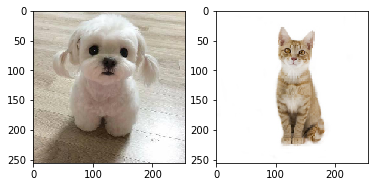

In [22]:
fig = plt.figure()

for idx in range(2):
    ax = fig.add_subplot(1,2,idx+1)
    ax.imshow(flipped_lr[idx] / 255)

# fig.savefig('./dog_cat_flipped_lr.png')

### Flipping up, down
예시로 보여주기위해서 `tf.image.flip_up_down` 를 사용하였으나, 실제 training하기위해서 model에 넘길때는 mini-batch를 뽑을 때마다 무작위성을 부여하기위해 `tf.image.random_flip_up_down` 를 사용한다.

In [23]:
tf.reset_default_graph()
img = tf.placeholder(dtype = tf.float32, shape = [None, 256, 256, 3])

flipping_ud = tf.image.flip_up_down(image = img)
with tf.Session() as sess:
    flipped_ud = sess.run(flipping_ud, feed_dict = {img : images})

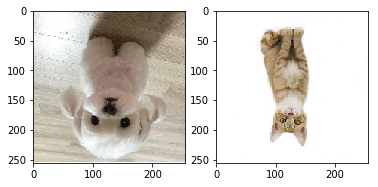

In [24]:
fig = plt.figure()

for idx in range(2):
    ax = fig.add_subplot(1,2,idx+1)
    ax.imshow(flipped_ud[idx] / 255)

# fig.savefig('./dog_cat_flipped_ud.png')

### Adjusting contrast
예시로 보여주기위해서 `tf.image.adjust_contrast` 를 사용하였으나, 실제 training하기위해서 model에 넘길때는 mini-batch를 뽑을 때마다 무작위성을 부여하기위해 `tf.image.random_contrast` 를 사용한다.

In [25]:
tf.reset_default_graph()
img = tf.placeholder(dtype = tf.float32, shape = [None, 256, 256, 3])

adjusting_contrast = tf.image.adjust_contrast(images = img, contrast_factor = .5)
with tf.Session() as sess:
    adjusted_contrast = sess.run(adjusting_contrast, feed_dict = {img : images})

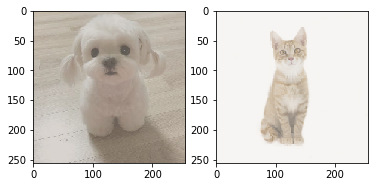

In [26]:
fig = plt.figure()

for idx in range(2):
    ax = fig.add_subplot(1,2,idx+1)
    ax.imshow(adjusted_contrast[idx] / 255)

# fig.savefig('./dog_cat_adjusted_contrast.png')

### Adjusting brightness
예시로 보여주기위해서 `tf.image.adjust_brightness` 를 사용하였으나, 실제 training하기위해서 model에 넘길때는 mini-batch를 뽑을 때마다 무작위성을 부여하기위해 `tf.image.random_brightness` 를 사용한다.

In [27]:
tf.reset_default_graph()
img = tf.placeholder(dtype = tf.float32, shape = [None, 256, 256, 3])

adjusting_brightness = tf.image.adjust_brightness(image = img, delta = .3)
adjusting_brightness = tf.clip_by_value(t = adjusting_brightness, clip_value_min = 0., clip_value_max = 255.)

with tf.Session() as sess:
    adjusted_brightness = sess.run(adjusting_brightness, feed_dict = {img : images})

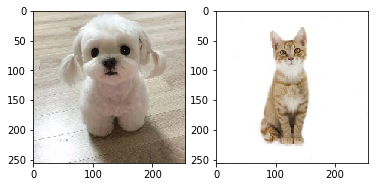

In [28]:
fig = plt.figure()

for idx in range(2):
    ax = fig.add_subplot(1,2,idx+1)
    ax.imshow(adjusted_brightness[idx] / 255)

# fig.savefig('./dog_cat_adjusted_brightness.png')

### Adjusting saturation
예시로 보여주기위해서 `tf.image.adjust_saturation` 를 사용하였으나, 실제 training하기위해서 model에 넘길때는 mini-batch를 뽑을 때마다 무작위성을 부여하기위해 `tf.image.random_saturation` 를 사용한다.

In [29]:
tf.reset_default_graph()
img = tf.placeholder(dtype = tf.float32, shape = [None, 256, 256, 3])

adjusting_saturation = tf.image.adjust_saturation(image = img, saturation_factor = .5)
with tf.Session() as sess:
    adjusted_saturation = sess.run(adjusting_saturation, feed_dict = {img : images})

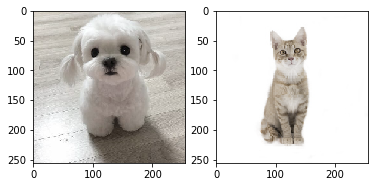

In [30]:
fig = plt.figure()

for idx in range(2):
    ax = fig.add_subplot(1,2,idx+1)
    ax.imshow(adjusted_saturation[idx] / 255)

# fig.savefig('./dog_cat_adjusted_saturation.png')

### Adjusting hue
예시로 보여주기위해서 `tf.image.adjust_hue` 를 사용하였으나, 실제 training하기위해서 model에 넘길때는 mini-batch를 뽑을 때마다 무작위성을 부여하기위해 `tf.image.random_hue` 를 사용한다.

In [31]:
tf.reset_default_graph()
img = tf.placeholder(dtype = tf.float32, shape = [None, 256, 256, 3])

adjusting_hue = tf.image.adjust_hue(image = img, delta = .5)
with tf.Session() as sess:
    adjusted_hue = sess.run(adjusting_hue, feed_dict = {img : images})

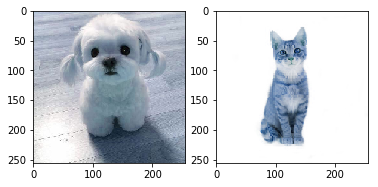

In [32]:
fig = plt.figure()

for idx in range(2):
    ax = fig.add_subplot(1,2,idx+1)
    ax.imshow(adjusted_hue[idx] / 255)

# fig.savefig('./dog_cat_adjusted_hue.png')

### Template
위의 augmentation 적용할 때는 `function` 을 만들어놓고, `tf.data.Dataset` class의 instance를 생성한 다음, instane의 `map` instance method를 활용한다.

#### Defining `augment_image function`

In [33]:
tf.reset_default_graph()

def augment_image(img):
    # flipping
    augmented = tf.image.random_flip_left_right(image = img)
    augmented = tf.image.random_flip_up_down(image = augmented)
    
    # brightness, saturation, hue, contrast
    augmented = tf.image.random_brightness(image = augmented, max_delta=32./255.)
    augmented = tf.image.random_saturation(image = augmented, lower=0.5, upper=1.5)
    augmented = tf.image.random_hue(image = augmented, max_delta=0.2)
    augmented = tf.image.random_contrast(image = augmented, lower=0.5, upper=1.5)
    augmented = tf.clip_by_value(t = augmented, clip_value_min = 0., clip_value_max = 255.)
    
    return augmented

#### `tf.data.Dataset` class의 instance의 `map` instance method 활용

In [34]:
dataset = tf.data.Dataset.from_tensor_slices(images)
dataset = dataset.map(lambda elm : augment_image(elm))
iterator = dataset.make_one_shot_iterator()
augmented_img = iterator.get_next()

In [35]:
with tf.Session() as sess:
    result = np.array([]).reshape(-1,256,256,3)
    try:
        while True:
            tmp = sess.run(augmented_img)
            tmp = tmp.reshape(-1,256,256,3)
            result = np.r_[result, tmp]
    except tf.errors.OutOfRangeError as e:
        pass

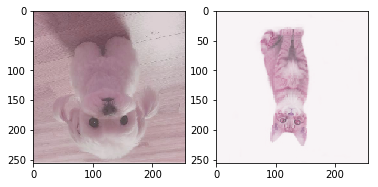

In [36]:
fig = plt.figure()

for idx in range(2):
    ax = fig.add_subplot(1,2,idx+1)
    ax.imshow(result[idx] / 255)

# fig.savefig('./dog_cat_augmented_template.png')

## Template
**Flipping and adjusting contrast, brightness, saturation, hue** 과 **cropping** section에서 정의한 `augment_image` , `crop_image` function을 아래와 같이 동시에 활용하여 model을 training시킬 때 data를 전달한다.

In [37]:
tf.reset_default_graph()

dataset = tf.data.Dataset.from_tensor_slices(images)
dataset = dataset.map(lambda elm : augment_image(elm))
dataset = dataset.map(lambda elm : crop_image(elm, crop_size=224, mode = 'ct'))
iterator = dataset.make_one_shot_iterator()
augmented_img = iterator.get_next()

In [38]:
with tf.Session() as sess:
    result = np.array([]).reshape(-1,224,224,3)
    try:
        while True:
            tmp = sess.run(augmented_img)
            tmp = tmp.reshape(-1,224,224,3)
            result = np.r_[result, tmp]
    except tf.errors.OutOfRangeError as e:
        pass

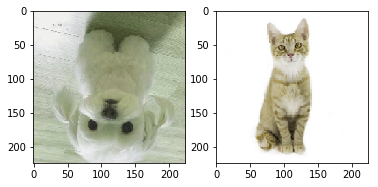

In [39]:
fig = plt.figure()

for idx in range(2):
    ax = fig.add_subplot(1,2,idx+1)
    ax.imshow(result[idx] / 255)

# fig.savefig('./dog_cat_template.png')